Author: Nikko V. salcedo
This is a classification model development using keras and tensorflow to detect hurricane damage using satellite images.  

Available dataset:  
Training - 10,0000  
Validation - 2,000  
Test - 9,000  

Image resolution is at (256X256)

# Part 1. Import all needed packages

In [152]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_recall_curve
import seaborn as sns
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import random
import matplotlib.pyplot as plt
sns.set()

# Part 2. Pre-procesing
a. Image resizing: (256, 256) -> (128, 128)  
b. Grayscale: None
c. Augmentations: None  
d. Shufflled: None

In [153]:
# Dataset Image paths
TEST_LOC= "../../datasets/sat_images/test_another"
TRAIN_LOC = "../../datasets/sat_images/train_another"
VAL_LOC = "../../datasets/sat_images/validation_another"

#Other global variables:
IMG_SIZE = (128,128)
BATCH_SIZE = 150
classes = {'no_damage':0, 'damage': 1,}

#Image Data Generator Objects

""" 
Augmentations done on trianing data:
1. rotation
2. zoom
3. reflect
4. vertical flip
5. horizontal flip
6. rescale

This is to avoid overfitting
"""
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.5,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0/255
)

test_idg =tf.keras.preprocessing.image.ImageDataGenerator( rescale=1.0/255)

#creating the datasets

train_gen = train_idg.flow_from_directory(TRAIN_LOC, IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb', shuffle=False,
                                         batch_size=BATCH_SIZE
                                         )

val_gen = train_idg.flow_from_directory(VAL_LOC, IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb', shuffle=False,
                                         batch_size=BATCH_SIZE
                                         )
test_gen = test_idg.flow_from_directory(TEST_LOC, IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb', shuffle=False,
                                         batch_size=1
                                         )


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


### Some functions for unpacking and viewing the data

In [154]:
def view_generator_data(gen, n):
    data = [next(gen) for _ in range(n)]
    data = list(zip(*data))
    X, y = data
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

def view_images(X, y, n=None):
    n = n or len(X)
    for i in range(n):
        plt.imshow(X[i])
        plt.grid(None)
        plt.show()
        print('Label: ', y[i])
test_gen.__len__()

9000

## Loading sample images for "damaged" class

From test dataset


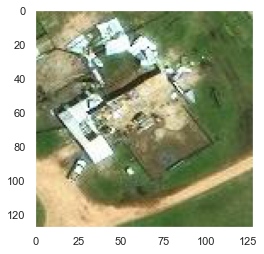

Label:  1.0

From Training dataset


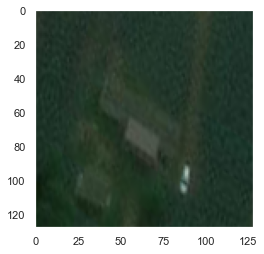

Label:  1.0

From validation dataset


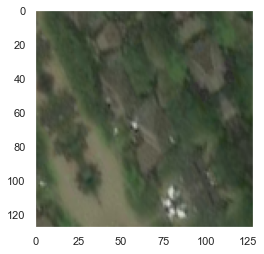

Label:  1.0


In [155]:
print("From test dataset")
(X,y) = test_gen.__getitem__(8996)
view_images(X,y)

print("\nFrom Training dataset")
(X,y) = train_gen.__getitem__(35)
view_images(X,y,1)

print("\nFrom validation dataset")
(X,y) = val_gen.__getitem__(11)
view_images(X,y,1)

## Loading samples of "no damage" class images

From test dataset


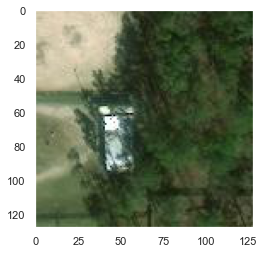

Label:  0.0

From Training dataset


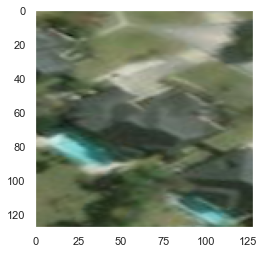

Label:  0.0

From validation dataset


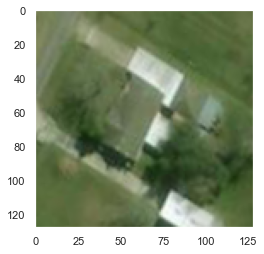

Label:  0.0


In [156]:
print("From test dataset")
(X,y) = test_gen.__getitem__(6)
view_images(X,y)

print("\nFrom Training dataset")
(X,y) = train_gen.__getitem__(5)
view_images(X,y,1)

print("\nFrom validation dataset")
(X,y) = val_gen.__getitem__(2)
view_images(X,y,1)

# Part 3. Defining the model architecture

3.a. Defining some variables

In [157]:
# Locations for saving models
MODEL_DIR = 'project_models/checkpoints3/model_at_{epoch:02d}.ckpt'
BEST_DIR = 'project_models/checkpoints3/best/best_model.ckpt'
os.makedirs(os.path.dirname(MODEL_DIR), exist_ok=True)
os.makedirs(os.path.dirname(BEST_DIR), exist_ok=True)

#loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits = False)

#optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0025)

#metrics
metrics = [tf.keras.metrics.BinaryAccuracy(threshold = 0.6)]

#callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_DIR)
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_DIR, save_best_only=True)

#Regularizer
l2 = tf.keras.regularizers.l2(0.005)

3.b. Model architecture

In [158]:
img_input = tf.keras.layers.Input((128,128,3))
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                        input_tensor = img_input)
X = base_model.output
#Lock weights value
base_model.trainable = False

#Flatten
#Flatten
fl1 = tf.keras.layers.Flatten()(X)
dense1 = tf.keras.layers.Dense(1028,activation='relu', kernel_regularizer=l2)(fl1)
dense2 = tf.keras.layers.Dense(100,activation='relu')(dense1)
output = tf.keras.layers.Dense(1,activation='sigmoid')(dense1)

#model creation
model = tf.keras.Model(inputs=img_input, outputs=output)
model.compile( optimizer=opt,loss=loss, metrics=metrics )

In [159]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

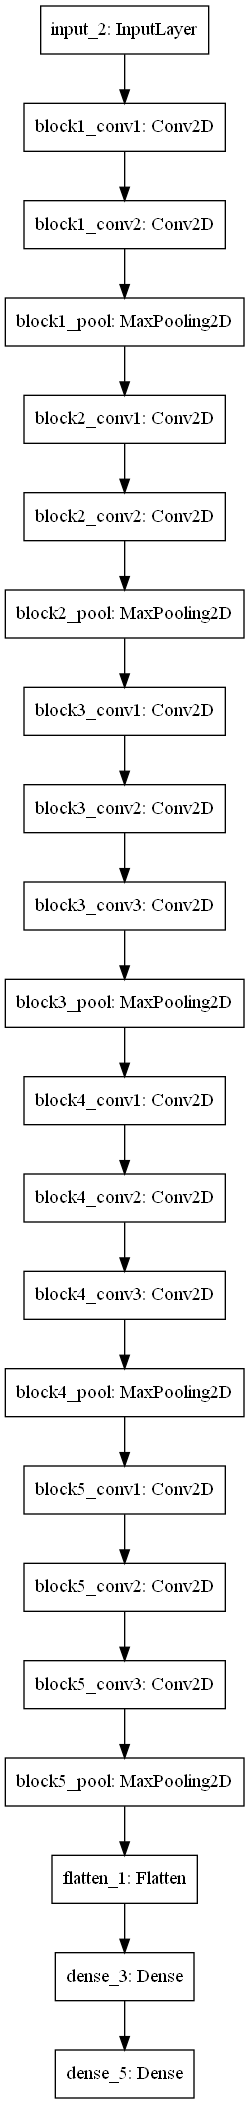

In [160]:
tf.keras.utils.plot_model(model)

In [ ]:
history = model.fit ( 
        train_gen,
        epochs =50,
        steps_per_epoch = 42,
        callbacks=[early_stop, model_checkpoint, best_checkpoint],
        validation_data = val_gen,
        validation_steps = 10
                      )

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 7.5358 - binary_accuracy: 0.5367INFO:tensorflow:Assets written to: project_models/checkpoints3/model_at_01.ckpt\assets
INFO:tensorflow:Assets written to: project_models/checkpoints3/best/best_model.ckpt\assets
42/42 [==============================] - 105s 3s/step - loss: 7.5358 - binary_accuracy: 0.5367 - val_loss: 1.9092 - val_binary_accuracy: 0.8013
Epoch 2/50
42/42 [==============================] - 45s 1s/step - loss: 1.4635 - binary_accuracy: 0.7951 - val_loss: 1.9112 - val_binary_accuracy: 0.6667
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.0595 - binary_accuracy: 0.7565INFO:tensorflow:Assets written to: project_models/checkpoints3/model_at_03.ckpt\assets
INFO:tensorflow:Assets written to: project_models/checkpoints3/best/best_model.ckpt\assets
42/42 [==============================] - 39s 925ms/step - loss: 1.0595 - binary_accuracy: 0.7565 - val_loss: 1.0994 - val_binary_accuracy: 0.6573


# Part 3. Visualizing Results

3.a. Charts for training and validation metrics

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

axes[0].plot(history.history[('binary_accuracy')])
axes[0].plot(history.history[('val_binary_accuracy')])
axes[0].legend(['training', 'validation'])
axes[0].set_title("Training and Validation Accuracy")
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].set_ylim([0,1])

axes[1].plot(history.history[('loss')])
axes[1].plot(history.history[('val_loss')])
axes[1].legend(['training', 'validation'])
axes[1].set_title("Training and Validation loss")
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].set_ylim([0,2])



plt.show()

Loading the Best Model

In [ ]:
TEST_LOC_LIGHT= "../../datasets/sat_images/test_light"

test_idg_light = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

test_gen_light = test_idg_light.flow_from_directory(TEST_LOC_LIGHT, IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb',   shuffle=False,
                                         batch_size=1
                                        )

In [ ]:
test_X, test_y = view_generator_data(test_gen_light, test_gen_light.n)

In [114]:
#best_model = tf.keras.models.load_model(BEST_DIR)
best_model = tf.keras.models.load_model('project_models/checkpoints3/model_at_32.ckpt')

In [115]:
y_pred = best_model.predict(test_X)

In [116]:
roc_auc_score(test_y, y_pred)

0.934481

In [117]:
y_pred.reshape(2000,)

array([0.23804906, 0.07586332, 0.04770786, ..., 0.897448  , 0.88602406,
       0.83679533], dtype=float32)

In [118]:
pr, r, thr = precision_recall_curve(test_y, y_pred)

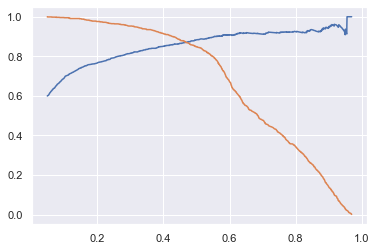

In [119]:
plt.plot(thr, pr[:-1])
plt.plot(thr, r[:-1])
plt.show()

In [148]:
threshold = 0.4
accuracy_score(test_y > threshold, y_pred > threshold)

0.8765

In [149]:
cm = confusion_matrix(test_y>threshold, y_pred > threshold)
cm

array([[839, 161],
       [ 86, 914]], dtype=int64)

In [150]:
print(classification_report(test_y>threshold, y_pred > threshold))

              precision    recall  f1-score   support

       False       0.91      0.84      0.87      1000
        True       0.85      0.91      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



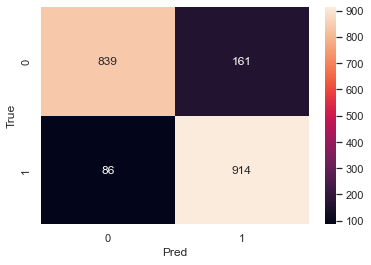

In [151]:
sns.heatmap(cm, annot=True, fmt="g")
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()